# How to solve the flow equations in OpenPNM

In this example, I will show how to solve the flow equations in OpenPNM

$$
Q = \sum\limits_{i = 1}^N {{q_i}}  = \sum\limits_{i = 1}^N {\sum\limits_{j = 1}^n {{g_{ij}}({P_j} - {P_i})} }  = 0
$$

First, construct a 2D PNM with 3 * 4 = 12 pores and 17 throats. 

This code script is run based on the version 2.5.0

In [2]:
import numpy as np
import openpnm as op
import matplotlib.pyplot as plt
import scipy as sp
import openpnm.models as mods
import openpnm.io.VTK as iovtk

In [3]:
pn = op.network.Cubic(shape=[3, 4, 1], spacing=0.0001)  # pore center distance is 0.1 mm
geo = op.geometry.GenericGeometry(network=pn, pores=pn.pores(),
                                  throats=pn.throats(), name='geo')
geo.add_model(propname='pore.seed',
             model=mods.misc.random,
             element='pore',
             num_range=[0.2, 0.7],
             seed=None)

geo.add_model(propname='pore.max_size',
              model=mods.geometry.pore_size.largest_sphere,
              iters=10)

geo.add_model(propname='pore.diameter',
              model=mods.misc.product,
              prop1='pore.max_size',
              prop2='pore.seed')

# set pore diameter is 50 microns
geo['pore.diameter'] = geo['pore.diameter'].min()
geo['pore.diameter'] =  5.00E-05
geo['throat.diameter'] = 2.50E-5  # throat diameter is 25 microns

In [4]:
geo.add_model(propname='pore.area',
              model=mods.geometry.pore_area.sphere)

geo.add_model(propname='pore.volume',
              model=mods.geometry.pore_volume.sphere)

geo.add_model(propname='throat.endpoints',
              model=mods.geometry.throat_endpoints.spherical_pores,
              pore_diameter='pore.diameter',
              throat_diameter='throat.diameter')

geo.add_model(propname='throat.length',
              model=mods.geometry.throat_length.piecewise,
              throat_endpoints='throat.endpoints')

geo.add_model(propname='throat.conduit_lengths',
              model=mods.geometry.throat_length.conduit_lengths,
              throat_endpoints='throat.endpoints',
              throat_length='throat.length')

geo.add_model(propname='throat.volume',
              model=mods.geometry.throat_volume.cylinder)

geo.add_model(propname='throat.area',
              model=mods.geometry.throat_area.cylinder)

geo.add_model(propname='throat.surface_area',
              model=mods.geometry.throat_surface_area.cylinder)

geo['throat.radius'] = geo['throat.diameter'] / 2

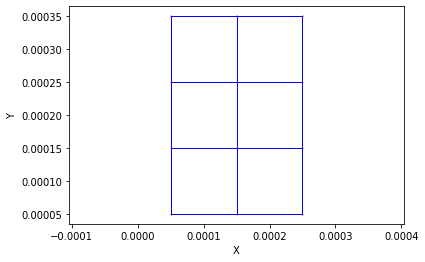

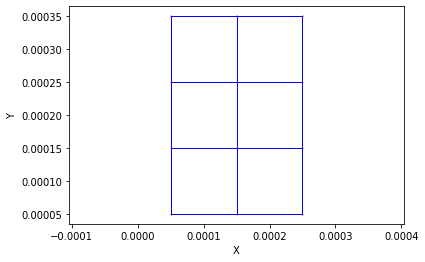

In [5]:
# quick plot
fig = op.topotools.plot_coordinates(pn)
op.topotools.plot_connections(pn, fig=fig)

In [ ]:
op.topotools.plot_tutorial(pn)

The above figure shows the pore indicies in blue circles and throat indices in black squares.

In [6]:
water = op.phases.Water(network=pn)

water.add_model(propname='throat.hydraulic_conductance',
                model=op.models.physics.hydraulic_conductance.hagen_poiseuille)

In [7]:
water['pore.pressure']

array([101325., 101325., 101325., 101325., 101325., 101325., 101325.,
       101325., 101325., 101325., 101325., 101325.])

In [8]:
water['throat.hydraulic_conductance']

array([1.80689199e-13, 1.80689199e-13, 1.80689199e-13, 1.80689199e-13,
       1.80689199e-13, 1.80689199e-13, 1.80689199e-13, 1.80689199e-13,
       1.80689199e-13, 1.80689199e-13, 1.80689199e-13, 1.80689199e-13,
       1.80689199e-13, 1.80689199e-13, 1.80689199e-13, 1.80689199e-13,
       1.80689199e-13])

In [9]:
inlets = [3, 7, 11]
outlets = [0, 4, 8]

In [10]:
flow = op.algorithms.StokesFlow(network=pn, phase=water)
flow.set_value_BC(pores=inlets, values=20)
flow.set_value_BC(pores=outlets, values=10)
flow.setup(phase= water, quantity='pore.pressure', conductance='throat.hydraulic_conductance')

flow.run()

In [11]:
flow['pore.pressure']

array([10.        , 13.33333333, 16.66666667, 20.        , 10.        ,
       13.33333333, 16.66666667, 20.        , 10.        , 13.33333333,
       16.66666667, 20.        ])

sparse matrix, (i, j) means, pores i and j are connected.

In [12]:
print(flow.A)

  (1, 2)	-1.8068919869130543e-13
  (5, 6)	-1.8068919869130543e-13
  (9, 10)	-1.8068919869130543e-13
  (1, 5)	-1.8068919869130536e-13
  (2, 6)	-1.8068919869130536e-13
  (5, 9)	-1.8068919869130543e-13
  (6, 10)	-1.8068919869130543e-13
  (2, 1)	-1.8068919869130543e-13
  (6, 5)	-1.8068919869130543e-13
  (10, 9)	-1.8068919869130543e-13
  (5, 1)	-1.8068919869130536e-13
  (6, 2)	-1.8068919869130536e-13
  (9, 5)	-1.8068919869130543e-13
  (10, 6)	-1.8068919869130543e-13
  (0, 0)	5.119527296253653e-13
  (1, 1)	5.420675960739162e-13
  (2, 2)	5.420675960739162e-13
  (3, 3)	5.119527296253653e-13
  (4, 4)	5.119527296253653e-13
  (5, 5)	7.227567947652215e-13
  (6, 6)	7.227567947652216e-13
  (7, 7)	5.119527296253653e-13
  (8, 8)	5.119527296253653e-13
  (9, 9)	5.420675960739162e-13
  (10, 10)	5.420675960739163e-13
  (11, 11)	5.119527296253653e-13


In [13]:
A_array = flow.A.todense()
A_array.shape

(12, 12)

In [14]:
flow.b

array([5.11952730e-12, 1.80689199e-12, 3.61378397e-12, 1.02390546e-11,
       5.11952730e-12, 1.80689199e-12, 3.61378397e-12, 1.02390546e-11,
       5.11952730e-12, 1.80689199e-12, 3.61378397e-12, 1.02390546e-11])

In [15]:
flow.b.shape

(12,)

The sparse matrix $Ax=b$ is solved using [Pardiso](https://www.pardiso-project.org/).

In [16]:
np.savetxt('matrix_a.txt', A_array)

## below is the code script by OpenPNM developers

https://github.com/PMEAL/OpenPNM/discussions/2227

In [17]:
import openpnm as op
import numpy as np

pn = op.network.Cubic([3, 3, 1])
a = op.phases.GenericPhase(network=pn)
a['throat.hydraulic_conductance'] = 1.0
sf = op.algorithms.StokesFlow(network=pn, phase=a)
sf.set_value_BC(pores=[0, 1, 2], values=1.0)
sf.set_value_BC(pores=[6, 7, 8], values=0.0)
print(sf.b)  # will be all zeros since we haven't actually set the BC yet
print(sf.A.todense())  # will be easily readable since the g_h values are just 1.0's
diag = sf.A.diagonal()  # Let's get a copy of the diagonal, which is used to compute f
print(diag)
f = np.mean(diag)
print(f)  # This has not been altered yet
sf._apply_BCs()  # A private method that get's called when you run sf
print(sf.b)  # Will now have some values in it

[0. 0. 0. 0. 0. 0. 0. 0. 0.]
[[ 2. -1.  0. -1.  0.  0.  0.  0.  0.]
 [-1.  3. -1.  0. -1.  0.  0.  0.  0.]
 [ 0. -1.  2.  0.  0. -1.  0.  0.  0.]
 [-1.  0.  0.  3. -1.  0. -1.  0.  0.]
 [ 0. -1.  0. -1.  4. -1.  0. -1.  0.]
 [ 0.  0. -1.  0. -1.  3.  0.  0. -1.]
 [ 0.  0.  0. -1.  0.  0.  2. -1.  0.]
 [ 0.  0.  0.  0. -1.  0. -1.  3. -1.]
 [ 0.  0.  0.  0.  0. -1.  0. -1.  2.]]
[2. 3. 2. 3. 4. 3. 2. 3. 2.]
2.6666666666666665
[2.66666667 2.66666667 2.66666667 1.         1.         1.
 0.         0.         0.        ]


In [18]:
diag = sf.A.diagonal()
print(diag)  # This has been altered by the application of the value BCs
print(sf.b / f)  # This should give the b values as I described previously, showing the BCs

[2.66666667 2.66666667 2.66666667 3.         4.         3.
 2.66666667 2.66666667 2.66666667]
[1.    1.    1.    0.375 0.375 0.375 0.    0.    0.   ]
